In [2]:
import math
import pandas as pd
import torch
import gpytorch
import numpy as np
import cf_units
import datetime
import xarray as xr
import dask
import dask.array as dsa
import zarr
from matplotlib import pyplot as plt


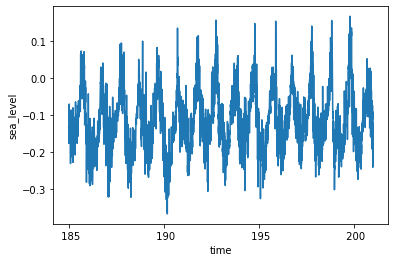

In [3]:
#First load data from xarray
sea_level_picontrol = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol.zarr')
rechunked = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')

# NOLA coords
coords = (29, -90)

# Grab the approximate chunk for provided coords
area_approx = rechunked.sea_level.sel(xt_ocean=coords[1], yt_ocean=coords[0], method="nearest")

# Set up the DataArray with data as the sea level of the approximate area, and time as it's dimension
coords_dict = {'time': sea_level_picontrol['time']}
area_sea_level = xr.DataArray(area_approx, dims=('time'), coords=coords_dict)

# Turn Data to tensors
time_int = cf_units.date2num(area_sea_level.time,'days since 0185-01-01 12:00:00' , calendar='julian')

# Note: I did not remove seasonal cycles
area_sea_level.plot()

In [51]:
def set_x_and_y(indexes, time, sea_level):
    """
    Input: array of indexes
    Output: Tensors for x and y (either train or test)
    """
    x = []
    y = [] 

    for i in indexes:
        x.append(time[i])
        y.append(sea_level[i])
        
    x = (np.array(x)).astype(float)
    y = (np.array(y)).astype(float)
        
    x = torch.FloatTensor(x).squeeze()
    y = torch.FloatTensor(y).squeeze()
    
    return x, y

def remove_gaps(indexes, gaps, gap_size):
    gaps_arr = np.random.choice(indexes[:len(indexes)-gap_size], gaps, False).reshape(-1, 1)
    for gap in gaps_arr:
        i = np.arange(gap, gap+gap_size)
        indexes = np.delete(indexes, i, 0)
        
    return indexes
        
def select_training_gaps(data_size, gaps, gap_size, time, sea_level):
    """
    Input: sea_level data
    Output: Tensors with x_train y_train, x_test, and y_test
    """
    
    # Randomly choose points for training, the rest for testing
    indexes = list(range(0, data_size))
    training_indexes = remove_gaps(indexes, gaps, gap_size)
    testing_indexes = np.setdiff1d(indexes, training_indexes).reshape(-1, 1)
    
    x_train, y_train = set_x_and_y(training_indexes, time, sea_level)
    x_test, y_test = set_x_and_y(testing_indexes, time, sea_level)
    
    return x_train, y_train, x_test, y_test

In [59]:
# Change how many points we're using, how many gaps in the data, and the size of the gaps
data_size = 500
gaps = 4
gap_size = 50

#Input: size of data, number of gaps, size of gaps, time data, sea level data
x_train, y_train, x_test, y_test = select_training_gaps(data_size, gaps, gap_size, time_int, area_sea_level)

<ipython-input-51-eddbc62d629f>:25: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  indexes = np.delete(indexes, i, 0)


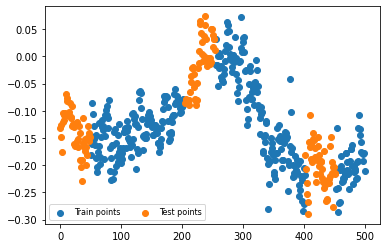

In [60]:
# Graph Our training and testing points
train_plt = plt.scatter(x_train, y_train)
test_plt = plt.scatter(x_test, y_test)
plt.legend((train_plt, test_plt),
           ('Train points', 'Test points'),
           loc='lower left',
           scatterpoints=1,
           ncol=3,
           fontsize=8)
plt.show()

In [123]:
#Create the GP model define -> ___ -> train -> predict
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(GaussianProcess, self).__init__(x_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.RQKernel()) #Why do we do ScaleKernel(...)
        
    def forward(self, x):
        """ Forward function
        Input:
        x: some n x d data
        
        Output:
        Multivariate Normal
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GaussianProcess(x_train, y_train, likelihood)

In [124]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()

In [125]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_test))

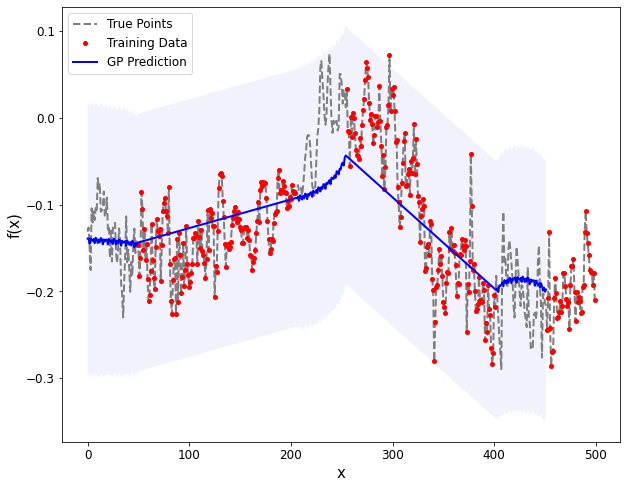

In [126]:
with torch.no_grad():
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot test function, training data and GP prediction
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(area_sea_level[:data_size],'C7--',linewidth=2,label='True Points')
    ax.plot(x_train, y_train,'ro',markerfacecolor='r', markersize=4, label='Training Data')
    ax.plot(x_test, observed_pred.mean.numpy(),'b-', lw=2, label='GP Prediction')
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, facecolor='lavender')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('f(x)', fontsize=15)
    ax.legend(loc="upper left",prop={'size': 12});